In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_squared_error,
mean_absolute_error,
mean_absolute_percentage_error, 
make_scorer)
#import scipy.stats as stats
from scipy import stats
from scipy.stats import rankdata

import shap

# import XGBClassifier
from xgboost import XGBRegressor

In [2]:
data=pd.concat([pd.read_csv(f'acoustic_indices/acoustic_indices_per_day_t{i}.csv').assign(temporada=f't{i}') 
                for i in range(1,5)])

In [3]:
data=data.astype({'day':'datetime64[ns]'})

Evaluar si el ruido antrópico (rms_db), afecta el paisaje sonoro (medido a través de los índices), controlando por efectos de
* Tipo de cobertura (Topo.de.cobertura)
* día (day)
* punto de muestreo (sensor_name).


In [4]:
indices=['BI','NDSI','SC']


In [5]:

temporada_summary=data.groupby('temporada').agg(start_date=('day','min'),
                              end_date=('day','max')
                             ).reset_index()


C:\Users\nicolas.betancourt\AppData\Local\Temp\ipykernel_8076\3739598540.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


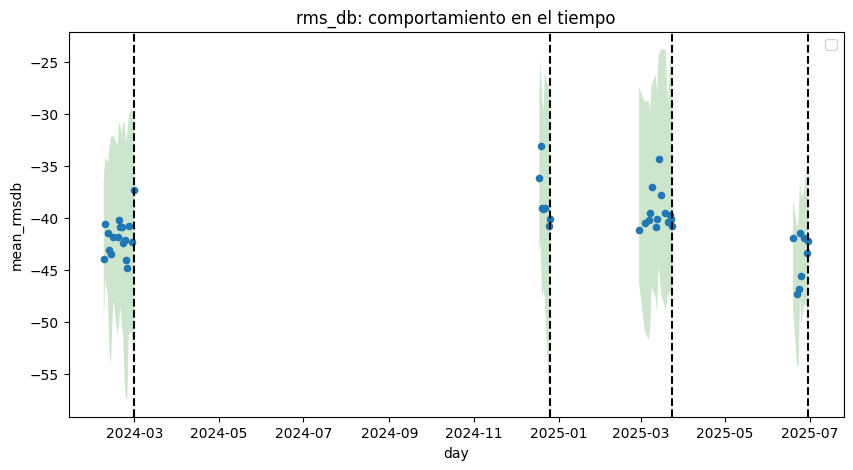

In [6]:
fig,ax=plt.subplots(figsize=(10,5))
df=data.groupby(['day']).agg(max_rmsdb=('rms_db','max'),
                             min_rmsdb=('rms_db','min'),
                            mean_rmsdb=('rms_db','mean')
                                    ).reset_index()


#df.plot(x='day',y='mean_rmsdb',ax=ax, kind='scatter')

ax.set_title(f'rms_db: comportamiento en el tiempo')
for idx_,row in temporada_summary.iterrows():
    ax.axvline(x=row['end_date'], 
                    ls='--', 
                    
                    color='k'
                   )
    df_temporada=df[(df['day']<=row['end_date'])
        &(df['day']>=row['start_date'])
        ]
    ax.fill_between(df_temporada['day'].values, df_temporada['max_rmsdb'], df_temporada['min_rmsdb'],
                    facecolor='green', alpha=0.2, interpolate=True)
    df_temporada.plot(x='day',y='mean_rmsdb',ax=ax, kind='scatter')
ax.legend()
fig.savefig('tendencia_rmsdb.png')

# Predecir índice en función de sensor, temporada, cobertura, rms y mes

In [7]:
indice='SC' # Esto determina qué índice se predice
indice=f'{indice}_mean'

In [8]:
data.loc[:,'month_y']=8*np.sin((2*np.pi*(data['day'].dt.month-1)/12))
data.loc[:,'month_x']=8*np.cos((2*np.pi*(data['day'].dt.month-1)/12))

In [9]:
data.loc[:,'sensor_name_y']=8*np.sin(2*np.pi*(data['sensor_name'].rank(method='dense', ascending=True)-1)/data['sensor_name'].nunique())
data.loc[:,'sensor_name_x']=8*np.cos(2*np.pi*(data['sensor_name'].rank(method='dense', ascending=True)-1)/data['sensor_name'].nunique())

In [10]:
#data.loc[:,'tipo_cobertura_y']=8*np.sin(2*np.pi*(data['Tipo de cobertura'].rank(method='dense', ascending=True)-1)/data['Tipo de cobertura'].nunique())
#data.loc[:,'tipo_cobertura_x']=8*np.cos(2*np.pi*(data['Tipo de cobertura'].rank(method='dense', ascending=True)-1)/data['Tipo de cobertura'].nunique())

In [11]:
data=pd.get_dummies(data, 
                    columns=['Tipo de cobertura','temporada'], 
                    #drop_first=True,
                
                    dtype='float64' )

In [12]:
features=['sensor_name_y','sensor_name_x', 'temporada_t1', 
          'temporada_t2', 'temporada_t3', 'temporada_t4', 'Tipo de cobertura_bosque denso',
       'Tipo de cobertura_pastos', 'Tipo de cobertura_vegetación secundaria', 'rms_db','month_y','month_x']

In [13]:
X_train, X_test, y_train, y_test=train_test_split(data[features], 
                                                  data[indice],
                                                  test_size=0.4, 
                                                  #random_state=42
                                                 )

In [14]:

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of boosting rounds (more can improve performance but increase training time)
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage to prevent overfitting (higher values speed up learning but risk overshooting)
    'max_depth': [3, 6, 9],  # Maximum depth of a tree (deeper trees can learn more but may overfit)
    #'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight in a child (higher values prevent deep trees)
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per tree (less than 1 helps prevent overfitting)
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree (lower values can reduce overfitting)
    #'gamma': [0, 0.1, 0.2],  # Minimum loss reduction to split a node (higher values make trees more conservative)
    #'reg_alpha': [0, 0.01, 0.1],  # L1 regularization term (encourages sparsity in weights, useful for high-dimensional data)
    #'reg_lambda': [1, 10, 100]  # L2 regularization term (helps control model complexity and avoid overfitting)
}
mape_scorer = make_scorer(mean_absolute_percentage_error, 
                      greater_is_better=False,)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring=mape_scorer, 
                           cv=5, verbose=1, n_jobs=-1)



grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8, ...], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 6, ...], 'n_estimators': [100, 300, ...], ...}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [15]:
best_xgb=grid_search.best_estimator_

In [16]:
y_pred=best_xgb.predict(X_test)
mape=mean_absolute_percentage_error(y_pred, y_test)
mse=mean_squared_error(y_pred, y_test)

In [17]:
print(mape, mse, np.sqrt(mse))

0.18113689768586527 0.004583963690908401 0.06770497537779924


In [18]:
data[indice].describe()

count    1239.000000
mean        0.328440
std         0.107658
min         0.000004
25%         0.278613
50%         0.340119
75%         0.390655
max         0.627073
Name: SC_mean, dtype: float64

 # Shap values

In [19]:
explainer = shap.Explainer(best_xgb,data[features])
shap_values = explainer(data[features])

In [20]:
shap_values_df=pd.DataFrame(shap_values.values,
             columns=[f"{columna}_shap" for columna in features]
            )

In [21]:
key_words=['temporada']
dummie_features=[ col for col in features if np.any([key_word in col for key_word in key_words])]
shap_values_df=pd.concat([shap_values_df.reset_index(),
                          data[features+[indice]].reset_index(),
                          pd.from_dummies(data[dummie_features].astype('int64'),default_category='temporada_1').rename(columns={'':'temporada'}).reset_index(drop=True)
                         ],
                         axis=1)

In [22]:
shap_values_df['normalized_rms_db']=rankdata(shap_values_df['rms_db'])/shap_values_df.shape[0]

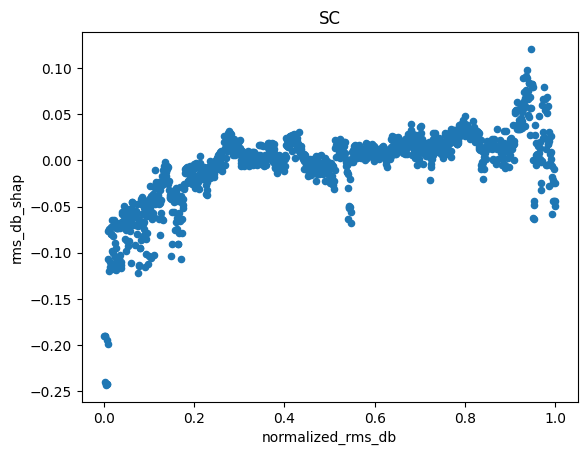

In [23]:
ax=shap_values_df.plot(x='normalized_rms_db', 
                    y='rms_db_shap',
                    kind='scatter',
                    title=indice.split('_')[0]
                   )
fig = ax.get_figure()
fig.savefig(f"{indice.split('_')[0]}_tendencial_plot_.png")
fig.savefig(f"{indice.split('_')[0]}_tendencial_plot_.pdf")

In [24]:
correlations_df=pd.DataFrame({'Variable 1':['Antropofonía','Antropofonía',' Valores Shap Antropofonía'],
                              'Variable 2': [' Valores Shap Antropofonía',
                                             f"Predicción modelo  ({indice.split('_')[0]})",
                                             f"Predicción modelo  ({indice.split('_')[0]})"],
                              
                              
                             })

correlations_df[['Valor correlación (Spearman)','p-value']]=[stats.spearmanr(shap_values_df['normalized_rms_db'],shap_values_df['rms_db_shap']),
                                                             stats.spearmanr(shap_values_df['normalized_rms_db'], best_xgb.predict(shap_values_df[features])),
                                                             stats.spearmanr(shap_values_df['rms_db_shap'], best_xgb.predict(shap_values_df[features]))
                                                             
                                                            ]

In [25]:
correlations_df

,Variable 1,Variable 2,Valor correlación (Spearman),p-value
0,Antropofonía,Valores Shap Antropofonía,0.715531,6.259471e-195
1,Antropofonía,Predicción modelo (SC),0.164871,5.299165e-09
2,Valores Shap Antropofonía,Predicción modelo (SC),0.402459,1.923996e-49


# Gráficas relativas a la temporada

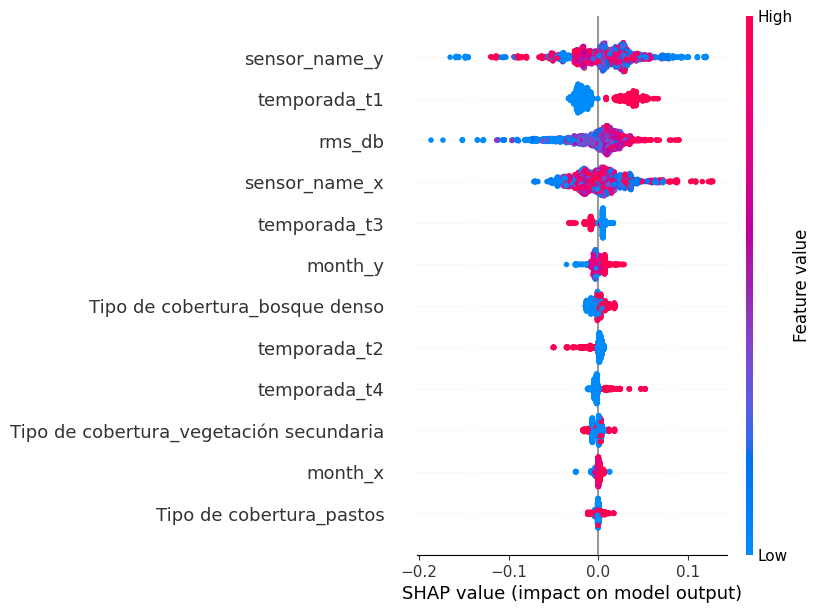

In [31]:
fig,ax=plt.subplots(figsize=(5,7))

shap.plots.beeswarm(shap_values,max_display=12,ax=ax, plot_size=None)

fig.savefig( f"{indice.split('_')[0]}_tendencial_shap_beeswarm.png", bbox_inches="tight", dpi=300)
fig.savefig( f"{indice.split('_')[0]}_tendencial_shap_beeswarm.pdf", bbox_inches="tight")

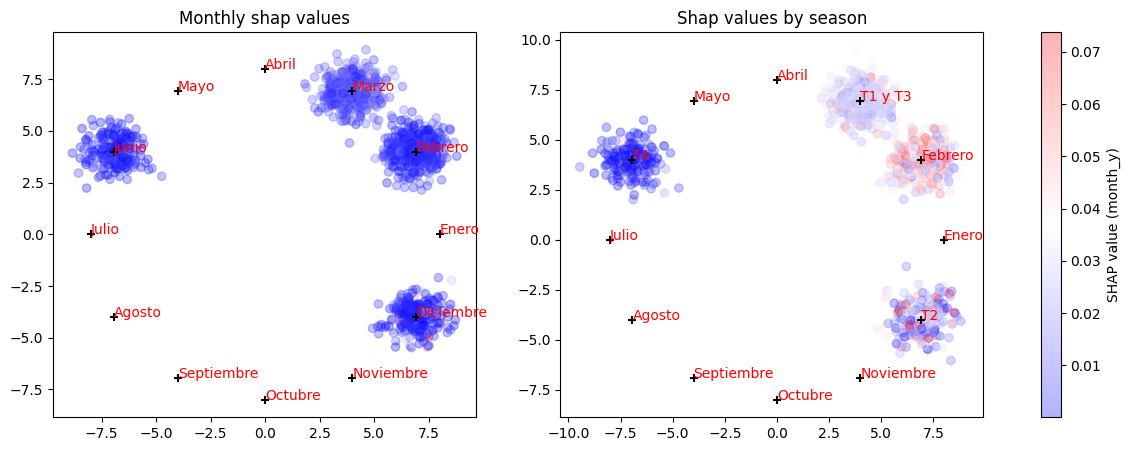

In [32]:
fig,ax=plt.subplots(ncols=2, figsize=(15,5))
##########
##########
##########
# Month ##
##########
##########
##########
annotations_color='red'
x_values=shap_values_df['month_x']+np.random.normal(0,0.7,len(shap_values_df))
y_values=shap_values_df['month_y']+np.random.normal(0,0.7,len(shap_values_df))

sc=ax[0].scatter(x_values,
              y_values,
            c= np.abs(shap_values_df['month_y_shap']+shap_values_df['month_y_shap']),
           cmap='bwr',   # choose a colormap
           alpha=0.3
          )

# Circle markers for months
angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
x_months = 8 * np.sin(angles)
y_months = 8 * np.cos(angles)

ax[0].scatter(x_months, y_months, marker='+', color='k', s=35)

month_names = [
    "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
]


# Add month labels
for idx_month, month in enumerate(month_names):
    x=8*np.cos(2*np.pi*idx_month/12)
    y=8*np.sin(2*np.pi*idx_month/12)
    ax[0].text(x, y, str(month), color=annotations_color
            #fontsize=9, ha="center", va="center",
            #xytext=(0, -10), textcoords="offset points"
           )


ax[0].set_title('Monthly shap values')

##########
##########
##########
# Season ##
##########
##########
##########
x_values=shap_values_df['month_x']+np.random.normal(0,0.7,len(shap_values_df))
y_values=shap_values_df['month_y']+np.random.normal(0,0.7,len(shap_values_df))

sc=ax[1].scatter(x_values,
              y_values,
            c= np.abs(shap_values_df[[f'temporada_t{i}_shap' for i in range(1,5)]].sum(axis=1)),
           cmap='bwr',   # choose a colormap
           alpha=0.3
          )

# Circle markers for months
angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
x_months = 8 * np.sin(angles)
y_months = 8 * np.cos(angles)

ax[1].scatter(x_months, y_months, marker='+', color='k', s=35)

month_names = [
    "Enero", "Febrero", "T1 y T3", "Abril", "Mayo", "T4",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "T2"
]


# Add month labels
for idx_month, month in enumerate(month_names):
    x=8*np.cos(2*np.pi*idx_month/12)
    y=8*np.sin(2*np.pi*idx_month/12)
    ax[1].text(x, y, str(month), 
            #fontsize=9, ha="center", va="center",
            #xytext=(0, -10), textcoords="offset points",
           color=annotations_color
           )

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("SHAP value (month_y)")  # label for clarity
ax[1].set_title('Shap values by season')



fig.savefig( f"{indice.split('_')[0]}_tendencial_polar_shap_values.png", bbox_inches="tight", dpi=300)
fig.savefig( f"{indice.split('_')[0]}_tendencial_polar_shap_values.pdf", bbox_inches="tight")